In [23]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.spatial.distance import cdist
from scipy.stats import ttest_ind
from scipy import stats

from paths import *
from ssd_paths import *

## Local path define

In [3]:
mapper_path = ssd_src_path + "mapper/mandarin_to_feats.xlsx"
# rec_name = "dim-3-1130161723"
# rec_name = "dim-3-1130205041"
# rec_name = "dim-3-1130222703"
rec_name = "dim-3-1130225525"
result_dir = root_path + "results/man/" + f"{rec_name}/"
mk(result_dir)

model_save_dir = model_man_save_dir + f"{rec_name}/"

## Define util functions

In [4]:
def get_data_pair(selected_guide, hiddens): 
    return hiddens[selected_guide.index.tolist()], selected_guide["covertag"].tolist()

def get_random_samples(guide, to_choose_tag, cover_tag, max_samples=500): 
    selected_guide = guide[guide["tag"] == to_choose_tag]
    count = len(selected_guide)
    if len(selected_guide) > max_samples: 
        selected_guide = selected_guide.sample(max_samples)
        count = max_samples
    selected_guide["covertag"] = cover_tag
    return selected_guide, count

def combine_guide(guides): 
    return pd.concat(guides)

def plot3dGroup(guide):
    config = {
    'toImageButtonOptions': {
        'format': 'png', # one of png, svg, jpeg, webp
        'filename': 'custom_image',
        'height': 1280,
        'width': 1280,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    }
    }
    fig = px.scatter_3d(guide, x="norm_0", y="norm_1", z="norm_2",
                color='tag')
    fig.update_traces(marker=dict(size=2),
                    selector=dict(mode='markers'))
    fig.update_layout(
        scene = dict(
            xaxis = dict(nticks=8, range=[-1,1],),
                        yaxis = dict(nticks=8, range=[-1,1],),
                        zaxis = dict(nticks=8, range=[-1,1],),),)
    fig.update_layout(legend= {'itemsizing': 'constant'})
    fig.update_layout(legend_title_text='Class')
    fig.update_layout(
        legend=dict(
            x=0,
            y=1,
            title_font_family="Times New Roman",
            font=dict(
                family="Times New Roman",
                size=36,
                color="black"
            ),
            # bgcolor="LightSteelBlue",
            bordercolor="Black",
            borderwidth=1
        )
    )
    fig.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),
    )
    camera = dict(
        eye=dict(x=0., y=0., z=2.5)
    )
    fig.update_layout(scene_camera=camera)
    html_plot = fig.to_html(full_html=False, config=config)
    # fig.show(config=config)
    return html_plot

def minmax(val, themin, themax, a=-1, b=1):
    return (b - a) * ((val - themin) / (themax - themin)) + a

## Load data

In [5]:
heim_hiddens = np.load(os.path.join(model_save_dir, "heim_hiddens.npy"))
heim_df = pd.read_csv(os.path.join(model_save_dir, "heim_encodes.csv"))

In [6]:
heim_df["tag"].unique()

array(['iang', 'z', 'ii', 'l', 'ian', 'x', 'v', 'j', 'iou', 'sh', 'en',
       'm', 'e', 'n', 'k', 'r', 'ei', 'd', 'ou', 'i', 'g', 'an', 'zh',
       'iii', 'uo', 'u', 'b', 'a', 't', 'ang', 'ch', 'eng', 'ui', 'ai',
       'ao', 'ie', 'uang', 'ing', 's', 'rr', 'iao', 'f', 'p', 'q', 've',
       'uan', 'h', 'in', 'un', 'ong', 'ia', 'van', 'c', 'ua', 'iong',
       'uai', 'vn', 'o'], dtype=object)

In [7]:
themin = heim_df["0"].min()
themax = heim_df["0"].max()
heim_df["norm_0"] = heim_df["0"].apply(lambda x: minmax(x, themin, themax))

themin = heim_df["1"].min()
themax = heim_df["1"].max()
heim_df["norm_1"] = heim_df["1"].apply(lambda x: minmax(x, themin, themax))

themin = heim_df["2"].min()
themax = heim_df["2"].max()
heim_df["norm_2"] = heim_df["2"].apply(lambda x: minmax(x, themin, themax))

In [48]:
def calculate_distances(group):
    # Calculate pairwise distances within the group
    distances_within_group = cdist(group, group)

    # Flatten the upper triangular part (excluding the diagonal) to get unique distances
    distances_within_group = distances_within_group[np.triu_indices(distances_within_group.shape[0], k=1)]

    return distances_within_group

def calculate_AB_distances(group_a, group_b):
    # Calculate distances between points in group_a and group_b
    distances_between_groups = cdist(group_a, group_b).flatten()

    return distances_between_groups

def perform_t_test(distances_a, distances_b, distances_ab):
    # Perform independent two-sample t-test
    t_statistic, p_value = ttest_ind(distances_a, distances_b)

    # Output the t-statistic and p-value
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")

    # Compare AB-distances to A-distances and B-distances
    t_statistic_ab_vs_a, p_value_ab_vs_a = ttest_ind(distances_ab, distances_a)
    t_statistic_ab_vs_b, p_value_ab_vs_b = ttest_ind(distances_ab, distances_b)

    # Output the results for AB-distances vs A-distances and AB-distances vs B-distances
    print(f"T-statistic (AB-distances vs A-distances): {t_statistic_ab_vs_a}")
    print(f"P-value (AB-distances vs A-distances): {p_value_ab_vs_a}")
    print(f"T-statistic (AB-distances vs B-distances): {t_statistic_ab_vs_b}")
    print(f"P-value (AB-distances vs B-distances): {p_value_ab_vs_b}")


def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    cis = stats.t.interval(confidence=confidence, df=n-1, loc=mean, scale=stats.sem(data))
    return mean, mean - cis[0], cis[1] - mean

def plot_mean_with_confidence_intervals(distances_a, distances_b, distances_ab):
    means = [np.mean(distances_a), np.mean(distances_b), np.mean(distances_ab)]
    confidence_intervals = [calculate_confidence_interval(distances_a),
                            calculate_confidence_interval(distances_b),
                            calculate_confidence_interval(distances_ab)]

    labels = ['A-distances', 'B-distances', 'AB-distances']

    plt.figure(figsize=(10, 6))
    plt.bar(labels, means, yerr=np.array(confidence_intervals)[:, [1, 2]].T, capsize=5, color=['blue', 'orange', 'green'])
    plt.title('Mean Distances with Confidence Intervals')
    plt.ylabel('Mean Distance')
    plt.show()

def plot_mean_with_confidence_intervals(distances_a, distances_b):
    means = [np.mean(distances_a), np.mean(distances_b)]
    confidence_intervals = [calculate_confidence_interval(distances_a),
                            calculate_confidence_interval(distances_b)]

    labels = ['A-distances', 'B-distances']

    print(confidence_intervals[0], confidence_intervals[1])

    plt.figure(figsize=(10, 6))
    plt.bar(labels, means, yerr=np.array(confidence_intervals)[:, [1, 2]].T, capsize=5, color=['blue', 'orange', 'green'])
    plt.title('Mean Distances with Confidence Intervals')
    plt.ylabel('Mean Distance')
    plt.show()

In [49]:
def combo_getdata(guide, hiddens, to_choose_tag, cover_tag, max_samples=500): 
    selected_guide, count = get_random_samples(guide, to_choose_tag, cover_tag, max_samples)
    selected_hiddens, selected_tags = get_data_pair(selected_guide, hiddens)
    return selected_hiddens

In [54]:
def plot_haha(group1_data, group2_data): 
    # Calculate mean and confidence interval for each group
    mean_group1 = np.mean(group1_data)
    ci_group1 = 1.96 * np.std(group1_data) / np.sqrt(len(group1_data))

    mean_group2 = np.mean(group2_data)
    ci_group2 = 1.96 * np.std(group2_data) / np.sqrt(len(group2_data))

    # Plotting
    plt.figure(figsize=(8, 6))

    plt.bar([1, 2], [mean_group1, mean_group2], yerr=[ci_group1, ci_group2], capsize=10)
    plt.xticks([1, 2], ['Group 1', 'Group 2'])
    plt.title('Mean and Confidence Interval for Two Groups')
    plt.ylabel('Mean +/- 95% CI')

    plt.show()

3.145554726748001 0.001660162897883251


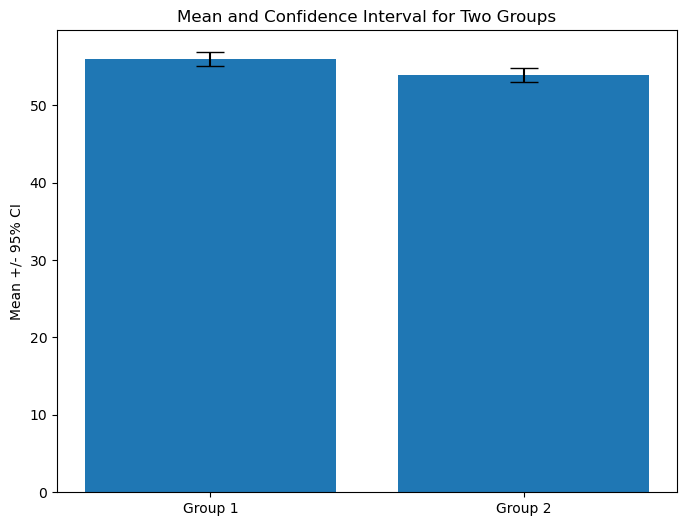

In [79]:
group_a = combo_getdata(heim_df, heim_hiddens, "d", "d", max_samples=100)
group_b = combo_getdata(heim_df, heim_hiddens, "t", "t", max_samples=100)

distances_a = calculate_distances(group_a)
distances_b = calculate_distances(group_b)
distance_aplusb = np.concatenate((distances_a, distances_b))
distances_ab = calculate_AB_distances(group_a, group_b)

# perform_t_test(distance_aplusb, distances_ab)
t_statistic_, p_value_ = ttest_ind(distances_ab, distance_aplusb)
print(t_statistic_, p_value_)
# plot_mean_with_confidence_intervals(distance_aplusb, distances_ab)

plot_haha(distances_ab, distance_aplusb)

In [80]:
def get_general_impression(tag_a, tag_b, size=100, rounds=100): 
    hit = 0
    for i in range(rounds):
        group_a = combo_getdata(heim_df, heim_hiddens, tag_a, tag_a, max_samples=size)
        group_b = combo_getdata(heim_df, heim_hiddens, tag_b, tag_b, max_samples=size)

        distances_a = calculate_distances(group_a)
        distances_b = calculate_distances(group_b)
        distance_aplusb = np.concatenate((distances_a, distances_b))
        distances_ab = calculate_AB_distances(group_a, group_b)

        # perform_t_test(distance_aplusb, distances_ab)
        t_statistic_, p_value_ = ttest_ind(distances_ab, distance_aplusb)
        if p_value_ < 0.05: 
            hit += 1
    return hit / rounds

In [81]:
get_general_impression("d", "t", size=100, rounds=100)

0.53

In [84]:
get_general_impression("a", "i", size=100, rounds=100)

1.0

In [86]:
get_general_impression("p", "t", size=100, rounds=100)

0.14

In [90]:
get_general_impression("b", "d", size=100, rounds=100)

0.4

In [91]:
get_general_impression("u", "v", size=100, rounds=100)

1.0

In [92]:
get_general_impression("i", "v", size=100, rounds=100)

1.0

In [93]:
get_general_impression("m", "n", size=100, rounds=100)

0.81

## Draw vowels

In [82]:
def proc_draw(guide, tags, max): 
    selected_guides = []
    num_counts = []
    for tag in tags: 
        selected_guide, count = get_random_samples(guide, tag, tag, max_samples=max)
        selected_guides.append(selected_guide)
        num_counts.append(count)

    combined_guide = combine_guide(selected_guides)
    outhtml = plot3dGroup(combined_guide)

    filename = "-".join(tags)
    outname = os.path.join(result_dir, f"{filename}.html")
    with open(outname, "w") as f:
        f.write('<meta charset="UTF-8">')
        f.write("<h3>Phones: {}</h3>".format(", ".join(tags)))
        # f.write("<h3>IPA: {}</h3>".format(", ".join(these_ipas)))
        f.write("<h3>Counts: {}</h3>".format(", ".join(map(str, num_counts))))
        f.write("<hr>")
        # f.write(outtable)
        f.write("<hr>")
        f.write(outhtml)

In [83]:
proc_draw(heim_df, ["sh", "r"], 3000)

/tmp/ipykernel_586652/3984330027.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_586652/3984330027.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [84]:
proc_draw(heim_df, ["a", "e", "i", "uo", "u", "v"], 1500)

/tmp/ipykernel_586652/3984330027.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_586652/3984330027.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_586652/3984330027.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [85]:
proc_draw(heim_df, ["d", "t"], 3000)

/tmp/ipykernel_586652/3984330027.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [86]:
proc_draw(heim_df, ["a", "e", "rr", "i", "u", "v"], 1500)

/tmp/ipykernel_586652/3984330027.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_586652/3984330027.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_586652/3984330027.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [87]:
proc_draw(heim_df, ["i", "ii", "iii"], 1500)

/tmp/ipykernel_586652/3984330027.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [88]:
proc_draw(heim_df, ["p", "t", "k"], 3000)

/tmp/ipykernel_586652/3984330027.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_586652/3984330027.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_586652/3984330027.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [89]:
# vowels = ["a", "e", "i", "uo", "u", "v"]
# selected_guides = []
# num_counts = []
# for vowel in vowels: 
#     selected_guide, count = get_random_samples(heim_df, vowel, vowel,max_samples=1000)
#     selected_guides.append(selected_guide)
#     num_counts.append(count)

# combined_guide = combine_guide(selected_guides)
# # selected_hiddens, selected_tags = get_data_pair(combined_guide, heim_hiddens)

# outhtml = plot3dGroup(combined_guide)

# outname = os.path.join(result_dir, "vowels.html")
# with open(outname, "w") as f:
#     f.write('<meta charset="UTF-8">')
#     # f.write("<h3>Phones: {}</h3>".format(", ".join(these)))
#     # f.write("<h3>IPA: {}</h3>".format(", ".join(these_ipas)))
#     # f.write("<h3>Counts: {}</h3>".format(", ".join(map(str, nums))))
#     f.write("<hr>")
#     # f.write(outtable)
#     f.write("<hr>")
#     f.write(outhtml)